# HeadHunter (hh.ru) - современные решения. Карьерный цех 2023.

## Библиотеки и файлы

In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from plotly import graph_objects as go
from scipy import stats
import math

import warnings
warnings.filterwarnings('ignore')

In [2]:
LOCAL_DATA_PATH = 'D:/dataset'

In [3]:
DATA_FILE_1 = 'vacs_metrics.csv'
DATA_FILE_2 = 'serps.csv'

In [4]:
vacs = pd.read_csv(f'{LOCAL_DATA_PATH}/{DATA_FILE_1}')

In [5]:
serps = pd.read_csv(f'{LOCAL_DATA_PATH}/{DATA_FILE_2}')

In [6]:
vacs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   vacancy_id_conv  55500 non-null  int64  
 1   metric_full      55500 non-null  float64
 2   emplpyer_id      55500 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 1.3 MB


In [7]:
serps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2431596 entries, 0 to 2431595
Data columns (total 4 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   request_id       object
 1   vacancy_id_conv  int64 
 2   city             object
 3   applicant        int64 
dtypes: int64(2), object(2)
memory usage: 74.2+ MB


In [8]:
vacs.head()

,vacancy_id_conv,metric_full,emplpyer_id
0,1,5.250818,640
1,2,5.808587,5123
2,3,2.830297,3325
3,4,5.179469,3511
4,5,5.457955,6604


In [9]:
serps.head()

,request_id,vacancy_id_conv,city,applicant
0,168719525526659303f2dee867dc6eda,48019,Moscow,78076
1,168719525526659303f2dee867dc6eda,45120,Moscow,614859
2,168719525526659303f2dee867dc6eda,18132,Moscow,175212
3,168719525526659303f2dee867dc6eda,29942,Moscow,322643
4,168719525526659303f2dee867dc6eda,32658,Moscow,722260


In [10]:
print('Общее количество плохих вакансий:', len(vacs[vacs['metric_full'] < 3]))
print('Доля плохих вакансий от общего количества вакансий:', round(len(vacs[vacs['metric_full'] < 3]) / len(vacs), 3))

Общее количество плохих вакансий: 8499
Доля плохих вакансий от общего количества вакансий: 0.153


## Группы исследования

Разделю вакансии случайным образом на две контрольные группы и одну тестовую:

In [11]:
#np.random.seed(0)
list = ['group_one', 'group_two', 'test']
vacs['group'] = np.random.choice(list, len(vacs))


In [12]:
vacs.sample(10)

,vacancy_id_conv,metric_full,emplpyer_id,group
26381,27232,5.092530,5550,group_two
28759,29702,6.385701,7867,group_one
22748,23435,5.207908,1722,group_one
50144,52192,0.530772,5633,group_one
28447,29373,5.621775,3692,test
3593,3702,4.602768,9781,group_one
32331,33417,4.811652,4367,test
48158,50035,5.092785,7582,group_one
13390,13778,5.206838,6950,test
42991,44582,5.587358,6578,test


In [13]:
vacs['group'].value_counts()

test         18647
group_one    18539
group_two    18314
Name: group, dtype: int64

Выборки приблизительно равны по количеству.

Объединю таблицы

In [14]:
df_merge = pd.merge(vacs, serps, how = 'left', on = 'vacancy_id_conv')

In [15]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2431596 entries, 0 to 2431595
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   vacancy_id_conv  int64  
 1   metric_full      float64
 2   emplpyer_id      int64  
 3   group            object 
 4   request_id       object 
 5   city             object 
 6   applicant        int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 148.4+ MB


Проверю данные на нормальность:

<Axes: >

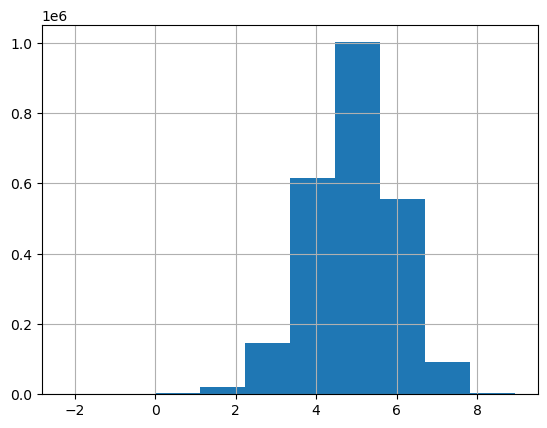

In [16]:
df_merge['metric_full'].hist()

Распределение метрики нормальное, есть небольшие выбросы, которые необходимо удалить.

<Axes: >

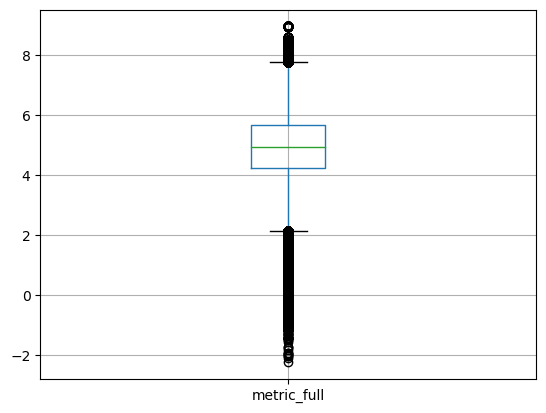

In [17]:
df_merge.boxplot(column=['metric_full'])

Бочка c усами показывает, что доверительный интервал находится в пределах от 2 до 8 скор. Соответственно отфильтрую таблицу по этому интервалу:

In [18]:
df = df_merge[(df_merge['metric_full'] > 2) & (df_merge['metric_full'] < 8)]

## Подготовка к A/A тесту

Проведу А/А тест двумя статистическими методами, что позволит снизить вероятность ошибки. В теории два разных метода должны дать одинаковый результат. В первом варианте использую z-тест, во втором - двухвыборочный t-критерий.

Z-тест, проверяет гипотезы для пропорции, или доли.

Двухвыборочный t-критерий, определяет равны ли два средних значения генеральной совокупности.

Разделю исследуемые группы вакансий на отдельные базы

In [19]:
one = df[df['group'] == 'group_one']
two = df[df['group'] == 'group_two']
test = df[df['group'] == 'test']
one.reset_index(drop=True, inplace=True)
two.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)


## Гипотезы

Нулевая гипотеза(H0): внедрение новой функции не повлияет на долю плохих вакансий в поисковых выдачах. Доля плохих компаний в тестовой и контрольной группах на самом деле не отличаются , и наблюдаемые различия случайные.

Альтернативная гипотеза(H1): внедрение новой функции уменьшит долю плохих компаний в поисковых выдачах. Доля плохих компаний в тестовой группе меньше, чем в контрольной, и эти различия - результат внедрений новой функции.

## Z-тест

#### Воронка вакансий

Разделю вакансии на четыре категории по показателю - скор. 

До 3 - плохие вакансии (bad)

От 3 до 4 - хорошие вакансии (good)

От 4 до 5 - очень хорошие вакансии (very_good)

От 5 - отличные вакансии (great)

In [20]:
def category(row):
    if row['metric_full'] < 3:
        return 'bad'
    if row['metric_full'] < 4:
        return 'good'
    if row['metric_full'] < 5:
        return 'very_good'
    else:
        return 'great'

In [21]:
df['category'] = df.apply(category, axis=1)
one['category'] = one.apply(category, axis=1)
two['category'] = two.apply(category, axis=1)
test['category'] = test.apply(category, axis=1)

In [22]:
df.sample(5)

,vacancy_id_conv,metric_full,emplpyer_id,group,request_id,city,applicant,category
2084028,43761,4.357219,4393,test,1687192671858acf83329482b64f0dd9,SPb,252408,very_good
1013004,17754,4.668242,2396,test,1687173473476b8cef3f3deb9ab35005,Penza,875740,very_good
10723,135,5.037726,9936,group_one,1687154330436590bd20e5821d5703f7,Samara,330494,great
2114225,44771,5.093907,4489,group_one,16871784968194c6d20d3d95170565f5,Moscow,333254,great
1112686,19692,5.730934,8105,test,1687172277580dcbe2552dc1166dfc2a,Moscow,442236,great


Подготовлю таблицу для графика воронки:

In [23]:
vacancy_funnel = df.groupby('category').agg(
    vacancy_serp=('vacancy_id_conv', 'count'),
    ).reset_index().sort_values(by='vacancy_serp', ascending=False)

In [24]:
vacancy_funnel

,category,vacancy_serp
2,great,1160052
3,very_good,816313
1,good,366401
0,bad,70656


In [25]:
fig = go.Figure(go.Funnel(y=vacancy_funnel['category'], x=vacancy_funnel['vacancy_serp'],
                textposition = "inside",
                textinfo = "value+percent previous+percent initial"))
fig.update_layout(title_text='График воронки')
fig.show(figsize=(12, 9))

#### График воронки с разделением по группам

Создам таблицу для каждой исследуемой группы:

In [26]:
group_one = one.groupby('category').agg(
    vacancy_serp=('vacancy_id_conv', 'count'),
    ).reset_index().sort_values(by='vacancy_serp', ascending=False)

In [27]:
group_two = two.groupby('category').agg(
    vacancy_serp=('vacancy_id_conv', 'count'),
    ).reset_index().sort_values(by='vacancy_serp', ascending=False)

In [28]:
group_test = test.groupby('category').agg(
    vacancy_serp=('vacancy_id_conv', 'count'),
    ).reset_index().sort_values(by='vacancy_serp', ascending=False)

In [29]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'group_one',
    y = group_one['category'],
    x = group_one['vacancy_serp'],
    textinfo = "value+percent initial"
    ))

fig.add_trace(go.Funnel(
    name = 'group_two',
    y = group_two['category'],
    x = group_two['vacancy_serp'],
    textinfo = "value+percent initial"
    ))

fig.add_trace(go.Funnel(
    name = 'test',
    y = group_test['category'],
    x = group_test['vacancy_serp'],
    textinfo = "value+percent initial"
    ))

fig.update_layout(title_text='График воронки с разделением по группам')
fig.show(figsize=(12, 9))

Судя по графику воронки, особой разницы между исследуемыми группами нет, но это утверждение необходимо подтвердить статистическими методами.

#### Таблицы для z-теста:

In [30]:
serp_group = df.pivot_table(index = 'group',
                                   columns = 'category',
                                   values = 'vacancy_id_conv',
                                   aggfunc = 'count').reset_index()

In [31]:
serp_count = df.groupby('group')['vacancy_id_conv'].size()


In [32]:
serp_group['serp_count'] = serp_group['group'].apply(lambda x: serp_count.loc[x])


In [33]:
serp_group = serp_group.set_index('group')


In [34]:
serp_group = serp_group[['great', 'very_good', 'good', 'bad', 'serp_count']]


In [35]:
serp_group

category,great,very_good,good,bad,serp_count
group,,,,,
group_one,377630,262371,117639,21230,778870
group_two,377878,255319,127759,26398,787354
test,404544,298623,121003,23028,847198


#### Критический уровень статистической значимости и поправки для множественного сравнения:

Проблема множественного сравнения заключается в том, что вероятность сделать неверное заключение в отношении хотя бы одной из гипотез значительно превышает изначально принятый уровень значимости (для А/А теста обычно α =0.01).
Для устранения этого эффекта необходимо использовать поправку Бонферрони.
Посчитаю поправку Бонферрони:
В тесте участвуют 3 группы по четыре шага. Итого m=12 гипотез.

In [36]:
m = 12
alpha = 0.01/m
alpha

0.0008333333333333334

#### Функция z-теста

In [37]:
def z_test(part0, part1, total0, total1):
    p1 = part0 / total0
    p2 = part1 / total1
    p_combined = (part0 + part1) / (total0 + total1)
    difference = p1 - p2
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/total0 + 1/total1))
    distr = stats.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value

#### A/A z-тест между контрольными группами:

In [38]:
AA_test = pd.DataFrame(columns=['group_one', 'group_two', 'category', 'p_alpha', 'p_value', 'Результат'])

result_options = ["Отвергаем нулевую гипотезу",
                  "Не получилось отвергнуть нулевую гипотезу"]

group_1 = 'group_one'
current_row = serp_group.loc[group_1]
group_2 = 'group_two'
for serp_number in range(4):
    curr_serp = serp_group.columns[serp_number]
    p_value_result = z_test(current_row[curr_serp],
                                   serp_group[curr_serp][group_2],
                                   current_row['serp_count'],
                                   serp_group['serp_count'][group_2]
                           )
    new_row = {'group_one': group_1,
               'group_two': group_2,
               'category': serp_group.columns[serp_number],
               'p_alpha': alpha,
               'p_value': round(p_value_result, 4),
               'Результат': result_options[p_value_result >= alpha]}
    AA_test = AA_test._append([new_row])

AA_test.index = range(len(AA_test))
AA_test

,group_one,group_two,category,p_alpha,p_value,Результат
0,group_one,group_two,great,0.000833,0.0,Отвергаем нулевую гипотезу
1,group_one,group_two,very_good,0.000833,0.0,Отвергаем нулевую гипотезу
2,group_one,group_two,good,0.000833,0.0,Отвергаем нулевую гипотезу
3,group_one,group_two,bad,0.000833,0.0,Отвергаем нулевую гипотезу


#### A/A z-тест между контрольной группой group_one и тестовой группой group_test:

In [39]:
AA_test = pd.DataFrame(columns=['group_one', 'test', 'category', 'p_alpha', 'p_value', 'Результат'])

result_options = ["Отвергаем нулевую гипотезу",
                  "Не получилось отвергнуть нулевую гипотезу"]

group_1 = 'group_one'
current_row = serp_group.loc[group_1]
group_2 = 'test'
for serp_number in range(4):
    curr_serp = serp_group.columns[serp_number]
    p_value_result = z_test(current_row[curr_serp],
                                   serp_group[curr_serp][group_2],
                                   current_row['serp_count'],
                                   serp_group['serp_count'][group_2]
                           )
    new_row = {'group_one': group_1,
               'test': group_2,
               'category': serp_group.columns[serp_number],
               'p_alpha': alpha,
               'p_value': round(p_value_result, 4),
               'Результат': result_options[p_value_result >= alpha]}
    AA_test = AA_test._append([new_row])

AA_test.index = range(len(AA_test))
AA_test

,group_one,test,category,p_alpha,p_value,Результат
0,group_one,test,great,0.000833,0.0000,Отвергаем нулевую гипотезу
1,group_one,test,very_good,0.000833,0.0000,Отвергаем нулевую гипотезу
2,group_one,test,good,0.000833,0.0000,Отвергаем нулевую гипотезу
3,group_one,test,bad,0.000833,0.7659,Не получилось отвергнуть нулевую гипотезу


## Т-тест

Для теста использую двухвыборочный t-критерий, который определяет равны ли два средних значения генеральной совокупности.

Добавлю столбец с меткой bad - good в таблицы групп. Точка раздела скор=3. bad=1, good=0

In [40]:
def goodbad(row):
    if row['metric_full'] < 3:
        return 1
    else:
        return 0

In [41]:
df['good-bad'] = df.apply(goodbad, axis=1)

Разделю базу на группы:

In [42]:
group_one = df[df['group'] == 'group_one']
group_two = df[df['group'] == 'group_two']
test = df[df['group'] == 'test']
group_one.reset_index(drop=True, inplace=True)
group_two.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

В каждой группе случайным образом создам по 50 среднестатистических пользователей

In [43]:
#np.random.seed(0) #даёт неизменность данных
group_one['user_random'] = np.random.randint(1, 51, size=len(group_one))
group_two['user_random'] = np.random.randint(52, 102, size=len(group_two))
test['user_random'] = np.random.randint(103, 153, size=len(test))

In [44]:
portret_one = group_one.groupby('user_random').agg(
    vacancy_serp=('vacancy_id_conv', 'count'),
    metric_mean=('metric_full', 'mean'),
    bad_vacancy_serp=('good-bad', 'sum')
).reset_index()

In [45]:
portret_two = group_two.groupby('user_random').agg(
    vacancy_serp=('vacancy_id_conv', 'count'),
    metric_mean=('metric_full', 'mean'),
    bad_vacancy_serp=('good-bad', 'sum')
).reset_index()

In [46]:
portret_test = test.groupby('user_random').agg(
    vacancy_serp=('vacancy_id_conv', 'count'),
    metric_mean=('metric_full', 'mean'),
    bad_vacancy_serp=('good-bad', 'sum')
).reset_index()

Добавлю столбец - доля плохих вакансий в поисковой выдаче: 

In [47]:
portret_one['rate_bad_serp, %'] = (portret_one['bad_vacancy_serp'] / portret_one['vacancy_serp'] * 100).round(2)
portret_two['rate_bad_serp, %'] = (portret_two['bad_vacancy_serp'] / portret_two['vacancy_serp'] * 100).round(2)
portret_test['rate_bad_serp, %'] = (portret_test['bad_vacancy_serp'] / portret_test['vacancy_serp'] * 100).round(2)

Прежде чем приступить к тесту сравню дисперсию групп:

In [48]:
print(np.var(portret_one['rate_bad_serp, %']), np.var(portret_two['rate_bad_serp, %']))
print(np.var(portret_one['rate_bad_serp, %']), np.var(portret_test['rate_bad_serp, %']))

0.013922439999999998 0.025464160000000007
0.013922439999999998 0.013231999999999996


Дисперсии отличаются незначительно, значит можно можно приступить к выполнению двухвыборочного t-критерия с равными дисперсиями:

В каждой группе проверю данные на нормальность, используя тест Шапиро-Уилка:

In [49]:
results = stats.shapiro(portret_one['rate_bad_serp, %'])
p_value = results[1] 

alpha = 0.05
if p_value > alpha:
    print('Нормальное распределение.')
else:
    print('Не нормальное распределение.')

Нормальное распределение.


In [50]:
results = stats.shapiro(portret_two['rate_bad_serp, %'])
p_value = results[1] 

alpha = 0.05
if p_value > alpha:
    print('Нормальное распределение.')
else:
    print('Не нормальное распределение.')

Нормальное распределение.


In [51]:
results = stats.shapiro(portret_test['rate_bad_serp, %'])
p_value = results[1] 

alpha = 0.05
if p_value > alpha:
    print('Нормальное распределение.')
else:
    print('Не нормальное распределение.')

Нормальное распределение.


#### A/A T-тест между контрольными группами:

In [52]:
alpha = 0.01
results = stats.ttest_ind(portret_one['rate_bad_serp, %'], portret_two['rate_bad_serp, %'], equal_var= True)

print('P-value: {0:.3f}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')

P-value: 0.000
Отвергаем нулевую гипотезу.


#### A/A T-тест между контрольной группой group_one и тестовой группой test:

In [53]:
alpha = 0.01
results = stats.ttest_ind(portret_one['rate_bad_serp, %'], portret_test['rate_bad_serp, %'], equal_var= True)

print('P-value: {0:.3f}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')

P-value: 0.716
Не получилось отвергнуть нулевую гипотезу.


## Вывод

Результаты А/А z-теста и Т-теста по случайной выборке вакансий из предложенной базы не дают основания к проведению А/В теста. 
Но вполне вероятно, и в теории так и должно быть, при исследовании большего количества поисковых выдач, можно добиться создания равных выборок.

С другой стороны, стоит ли овчинка выделки, если плохие вакансии имеют долю всего лишь 3.6% от общего количества поисковых выдач.